In [71]:
import os
import tarfile
import matplotlib.pyplot as plt
from six.moves import urllib

In [72]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets","housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

In [73]:
def fetch_housing_data(housing_url=HOUSING_URL,housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

fetch_housing_data()

In [74]:
import pandas as pd
import numpy as np
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path,"housing.csv")
    return pd.read_csv(csv_path)

In [75]:
housing = load_housing_data()

In [23]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [26]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [28]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

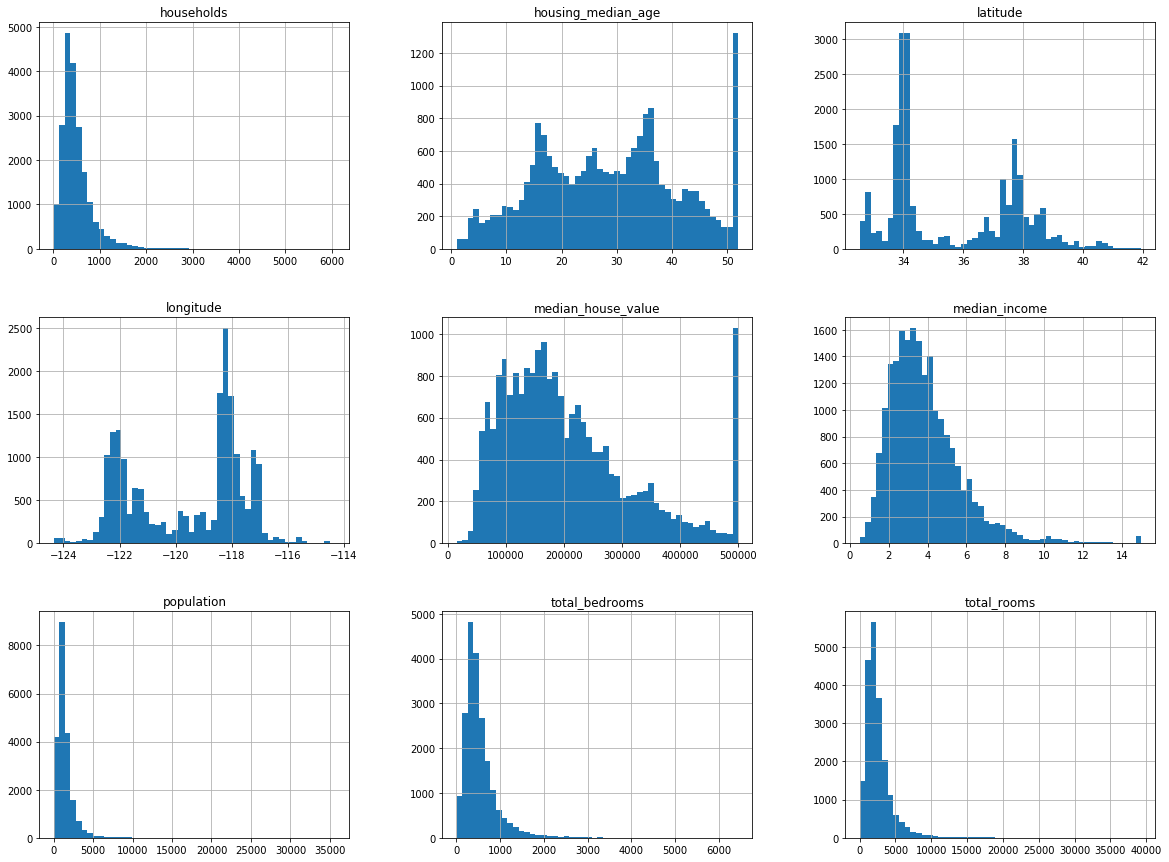

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50,figsize=(20,15))
plt.show()

In [76]:
housing['income_cat'] = np.ceil(housing['median_income']/1.5)

In [77]:
housing['income_cat'].where(housing['income_cat'] <5,5.0,inplace=True)

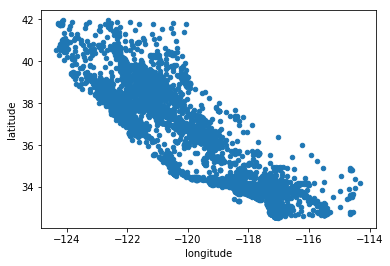

In [10]:
housing.plot(kind='scatter',x='longitude',y='latitude')

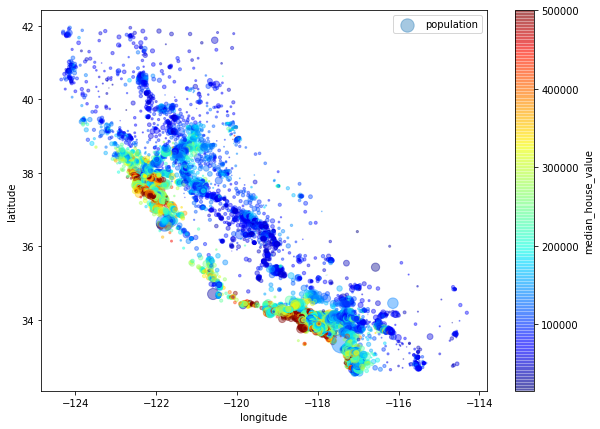

In [15]:
housing.plot(kind='scatter',x='longitude',y='latitude',alpha=0.4,s=housing['population']/100,label='population',figsize=(10,7),
            c='median_house_value',cmap=plt.get_cmap('jet'),colorbar=True,sharex=False)
plt.legend()

In [17]:
housing['rooms_per_household'] = housing['total_rooms']/housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms']/housing['total_rooms']
housing['population_per_household'] = housing['population']/housing['households']

In [18]:
corr = housing.corr()

In [70]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_cat
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN,2.0
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN,5.0
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN,2.0
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND,2.0
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,<1H OCEAN,3.0


In [78]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)
for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [80]:
for set_ in (strat_test_set,strat_train_set):
    set_.drop('income_cat',axis=1,inplace=True)

KeyError: "['income_cat'] not found in axis"

In [81]:
housing = strat_train_set.drop('median_house_value',axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

In [82]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')

In [83]:
housing_num = housing.drop('ocean_proximity',axis=1)

In [84]:
imputer.fit(housing_num)

SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbose=0)

In [85]:
X = imputer.transform(housing_num)

In [86]:
housing_cat = housing['ocean_proximity']
housing_cat_encoded,housing_categories = housing_cat.factorize()

In [30]:
housing_categories

Index(['<1H OCEAN', 'NEAR OCEAN', 'INLAND', 'NEAR BAY', 'ISLAND'], dtype='object')

In [87]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, household_ix = 3,4,5,6

class CombinedAttributesAdder(BaseEstimator,TransformerMixin):
    def __init__(self,add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix]/X[:,househole_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:,bedrooms_ix]/X[:,rooms_ix]
            return np.c_[X,rooms_per_household,population_per_household,bedrooms_per_room]
        else:
            return np.c_[X,rooms_per_household,population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [88]:
class DataFrameSelector(BaseEstimator,TransformerMixin):
    def __init__(self,attribute_names):
        self.attribute_names = attribute_names
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        return X[self.attribute_names].values

In [89]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

num_pipeline = Pipeline([('selector',DataFrameSelector(num_attribs)),
                         ('imputer',SimpleImputer(strategy='median')),
                         ('attribs_adder',CombinedAttributesAdder()),
                         ('std_scaler',StandardScaler())
                        ])

In [90]:
cat_pipeline = Pipeline([
    ('selector',DataFrameSelector(cat_attribs)),
    ('cat_encoder',OneHotEncoder()),
])

In [91]:
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline',num_pipeline),
    ('cat_pipeline',cat_pipeline),
])

In [92]:
housing_prepared = full_pipeline.fit_transform(housing)

In [141]:
housing_prepared[(0,9)]

-0.0864987054157523

In [114]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,<1H OCEAN


In [98]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared,housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [99]:
from sklearn.metrics import mean_squared_error
housing_prediction = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels,housing_prediction)
lin_rmse = np.sqrt(lin_mse)


In [100]:
lin_rmse

68628.19819848923

In [116]:
num_pipeline

Pipeline(memory=None,
     steps=[('selector', DataFrameSelector(attribute_names=['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income'])), ('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbose=0)), ('attribs_adder', CombinedAttributesAdder(add_bedrooms_per_room=True)), ('std_scaler', StandardScaler(copy=True, with_mean=True, with_std=True))])

In [117]:
cat_pipeline

Pipeline(memory=None,
     steps=[('selector', DataFrameSelector(attribute_names=['ocean_proximity'])), ('cat_encoder', OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='error',
       n_values=None, sparse=True))])